# Задание 1. Моделирование абстрактных типов данных (АТД) для различных реализаций

В соответствии с вариантом задания, необходимо реализовать следующие АТД:
* Стек на ОЛС, вершина стека - первый элемент ОЛС
* Очередь на ОЛС, "хвост" очереди - последний, а "голова" - первый элемент

Также необходимо реализовать классы, соответствующие следующим абстракциям:
* запрос к процессору
* процессор

Рассмотрим далее реализацию каждого из перечисленных пунктов задания.

## Стек

In [1]:
class Stack:
    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def push(self, item):
        self.items.insert(0, item)

    def pop(self):
        return self.items.pop(0)

    def peek(self):
        return self.items[0]

    def size(self):
        return len(self.items)

## Очередь

In [2]:
class CustomQueue:
    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def enqueue(self, item):
        self.items.insert(0, item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

## Запрос
Следует обратить внимание, что для внешней совместимости метод `get_info()` возвращает информацию об объекте в универсальном формате JSON, позволяя в дальнейшем обрабатывать запрос более гибким образом.

Имя запроса формируется в формате `имя@тип`, где `имя` задается параметром конструктора, а `тип` автоматически подставляется исходя из типа сгенерированного случайно запроса. К примеру, название объекта `zapros@2` означает, что при создании объекту было передано имя `zapros`, а при генерации этому объекту был присвоен второй тип.

In [3]:
from random import randint
import json


class Query:
    query_type = 0
    time = 0
    name = ""

    def __init__(self, name):
        self.query_type = randint(0, 2)
        self.name = name + "@" + str(self.query_type)
        self.time = randint(2, 10)

    def get_info(self):
        data = {
            'name': self.name,
            'query_type': self.query_type,
            'time': self.time,
        }
        return json.dumps(data)

## Процессор
Следует обратить внимание, что метод `get_info()` также возвращает данные об объекте в формате JSON.

In [4]:
from query import Query
import json


class Processor:
    is_free = True
    current_query = None
    time_left_for_query = 0
    name = ""

    def __init__(self, name):
        self.name = name

    def set_task(self, task: Query):
        self.is_free = False
        self.current_query = task
        self.time_left_for_query = task.time

    def next_tick(self):
        if self.time_left_for_query == 1:
            self.is_free = True
            self.current_query = None
            name = ""
        self.time_left_for_query -= 1

    def get_status(self):
        data = {
            'is_free': self.is_free,
            'current_query': self.current_query.name,
            'time_left_for_query': self.time_left_for_query,
            'processor_name': self.name
        }
        return json.dumps(data)

Все необходимые АТД и классы описаны корректно, следовательно, можно приступить в разработке модели, имитирующей поведение вычислительной системы.

# Разработка модели ВС

### Импортируем необходимые библиотеки:

In [5]:
import pandas as pd
from processor import Processor
from customqueue import CustomQueue
from stack import Stack
from query import Query
import json

import warnings
warnings.filterwarnings('ignore')

Поскольку данные об объекте передаются в формате JSON, создадим функцию, упрощающую взаимодействие с этим форматов в коде.

In [6]:
def decode(json_string):
    return json.loads(json_string)

Создадим базовые объекты, которые соответствуют 5-ому варианту задания. В частности, необходимо создать очередь для запросов, стек, куда будут отправляться запросы, которые нельзя обработать в данный момент и 3 процессора, каждый из которых будет обрабатывать свой тип запросов. Также ограничим суммарное число запросов - 10 000.

In [7]:
total_number_of_queries = 10000
queries = CustomQueue()
processors = [Processor("P0"), Processor("P1"), Processor("P2")]
awaiting_queries = Stack()

Опишем две вспомогательные функции, которые существенно упростят код и улучшат его читаемость:
* system_awaits() - проверяет состояние ВС, возвращая true, если она находится в режиме ожидания (ни один из процессоров не нагружен, стек запросов пусть, очередь запросов пуста), и false, если имеется хоть какая-либо активность ВС. Эту функцию мы будем использовать для проверки окончания работы ВС над запросами.
* fancy_status(processor) - функция, возвращающая описание состояния процессора в отформатированном виде для наглядности. Возвращается строка вида `Px: Query "n@p"; Time remaining:  t`, где `x` - номер процессора, `n` - присвоенное запросу имя, `p` - тип запроса, `t` - оставшееся время для выполнения запроса. В случае, если процессор свободен от задач, возникает исключение (exception) вида AttributeError, поскольку происходит обращение к аттрибуту со значением None, который аналогичен типу null в большинстве языков программирования. В этом случае исключение отлавливается и возвращается строка, извещающая о том, что процессор находится в состоянии ожидания.

In [8]:
def system_awaits():
    return (processors[0].is_free
           and processors[1].is_free
           and processors[2].is_free
           and awaiting_queries.is_empty()
           and queries.is_empty())

def fancy_status(processor):
    try:
        json_status = processor.get_status()
        parsed_status = decode(json_status)
        if not parsed_status['is_free']:
            return "{}: Query \"{:5}\"; Time remaining: {:2}".format(parsed_status['processor_name'],
                                                                     parsed_status['current_query'],
                                                                     parsed_status['time_left_for_query'])
    except AttributeError:
        return "{}: currently free.".format(processor.name)

Основная часть программы включает в себя цикл `while()`, который работает в соответствии с выполнением условия `not system_awaits()` (функция `system_awaits` описана выше). На каждой итерации, соответствующей имитации тика процессора, программа создает новый запрос, который помещает в очередь. Затем из головы очереди достается запрос, проверяется, свободен ли процессор, которому соответствует этот запрос, и если он свободен, помещается в него, иначе - переносится в стек. Затем происходит проверка, свободен ли процессор, соответствующий запросу в вершине стека. Если процессор свободен, задача помещается в него.

Для наглядности работы программы в файл логгируется нынешняя вершина стека и состояние каждого из процессоров. Также информация о каждом из процессоров и о величине стека заносится по соответствующим массивам `stack_size`, `p0_is_free`, `p1_is_free` и `p2_is_free`. В дальнейшем эти массивы мы будем использовать для анализа работы ВС.

In [9]:
with open('report.txt', 'w', encoding='utf-8') as f:
    query_number = 0
    queries.enqueue(Query(str(query_number)))
    query_number += 1
    size_of_stack = []
    p0_is_free = []
    p1_is_free = []
    p2_is_free = []

    while not system_awaits():
        if not queries.is_empty():
            new_query = queries.dequeue()
            # print(new_query.get_info(), ' ', query_number)
            f.write('Generated: ')
            f.write(new_query.get_info())
            f.write('\n')
            if processors[new_query.query_type].is_free:
                processors[new_query.query_type].set_task(new_query)
            else:
                awaiting_queries.push(new_query)

        if not awaiting_queries.is_empty():
            f.write('Top of stack: ')
            f.write(awaiting_queries.peek().get_info())
            f.write('\n')
            if processors[awaiting_queries.peek().query_type].is_free:
                processors[awaiting_queries.peek().query_type].set_task(awaiting_queries.pop())

        for i in processors:
            # print(fancy_status(i))
            f.write(fancy_status(i) + '\n')
            i.next_tick()
        # print('-' * 80)
        f.write('-' * 80 + '\n')

        if query_number < total_number_of_queries:
            queries.enqueue(Query(str(query_number)))
            query_number += 1

        size_of_stack.append(awaiting_queries.size())
        p0_is_free.append(processors[0].is_free)
        p1_is_free.append(processors[1].is_free)
        p2_is_free.append(processors[2].is_free)

Воспользуемся функционалом библиотеки pandas, созданной для удобной работы с большими объемами данных. Создадим объект типа `DataFrame`, двумерную таблицу, которая будет хранить в себе все данные о состоянии ВС в разные моменты времени, а затем сохраним эту информацию в формате .csv (comma-separated values).

In [10]:
df = pd.DataFrame({
    'stack_size': size_of_stack,
    'p0_is_free': p0_is_free,
    'p1_is_free': p1_is_free,
    'p2_is_free': p2_is_free
})
df.to_csv('raw_data.csv')

# Анализ состояний ВС

### Импортируем библиотеки, необходимые для анализа данных

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

Рассмотрим первые пять записей в таблице при помощи функции `head()`.

In [12]:
df = pd.read_csv('raw_data.csv', index_col=0)
df.head()

,p0_is_free,p1_is_free,p2_is_free,stack_size
0,False,True,True,0
1,False,True,False,0
2,False,True,False,1
3,False,True,False,2
4,True,True,False,3


Каждая запись представляет собой 4 последовательных значения в определенный момент времени. Значения описывают состояние каждого из процессоров и величину стека на данный момент.

Рассмотрим краткое описание формата данных при помощи метода `info()`.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32964 entries, 0 to 32963
Data columns (total 4 columns):
p0_is_free    32964 non-null bool
p1_is_free    32964 non-null bool
p2_is_free    32964 non-null bool
stack_size    32964 non-null int64
dtypes: bool(3), int64(1)
memory usage: 611.6 KB


Всего в датасете 32964 экземпляра, каждый из которых описывает состояние системы 4-мя значениями. Как видно выше, первые три колонки представляют собой объект типа `bool`, в то время как 4-ый представляет собой объект типа `int64`.

Для удобства анализа значений сведем тип `bool` также к типу `int64`.

In [14]:
df.p0_is_free = df.p0_is_free.astype('int64')
df.p1_is_free = df.p1_is_free.astype('int64')
df.p2_is_free = df.p2_is_free.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32964 entries, 0 to 32963
Data columns (total 4 columns):
p0_is_free    32964 non-null int64
p1_is_free    32964 non-null int64
p2_is_free    32964 non-null int64
stack_size    32964 non-null int64
dtypes: int64(4)
memory usage: 1.3 MB


Теперь все объекты являются объектами типа `int64`. Как видно из информационной сводки выше, все данные целостны, то есть нету отсутствующих или утерянных значений (таких, как `NaN`).

Рассмотрим общий анализ числовых данных датасета при помощи метода `describe()`.

In [15]:
df.describe()

,p0_is_free,p1_is_free,p2_is_free,stack_size
count,32964.000000,32964.000000,32964.000000,32964.000000
mean,0.494631,0.501820,0.489231,3063.705588
std,0.499979,0.500004,0.499892,1770.349645
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1528.750000
50%,0.000000,1.000000,0.000000,3072.000000
75%,1.000000,1.000000,1.000000,4601.000000
max,1.000000,1.000000,1.000000,6117.000000


Строки `25%`, `50%` и `75%` означают первый квантиль, медиану и третий квантиль соответственно. Как видно из значений, пиковая величина размера стека была 6117 элемент. Все значения процессоров близки к средним, то есть, процессоры находились в состоянии ожидания и работы приблизительно одинаковое время.

Рассмотрим график размера стека от номера тика процессора:

Text(0,0.5,'Size of stack')

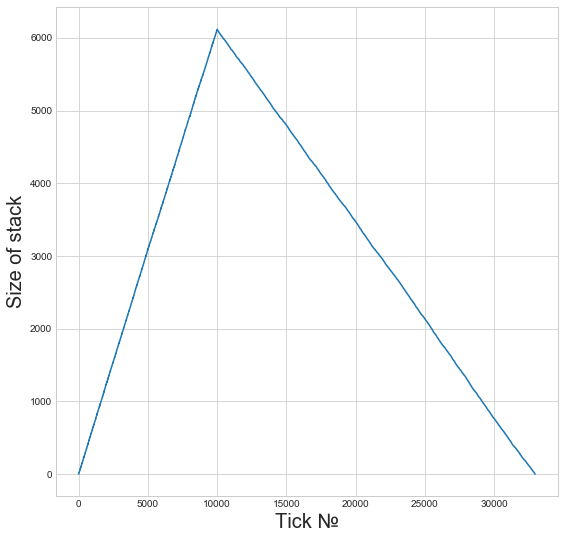

In [16]:
plt.figure(num=1, figsize=(9, 9))
plt.plot(df.index, df.stack_size)
plt.xlabel('Tick №', fontsize=20)
plt.ylabel('Size of stack', fontsize=20)

Наглядно видно, что размер стека увеличивается до тех пор, пока не наступает пороговое значение количества созданных запросов - 10 000. Затем размер стека постепенно уменьшается, полностью опустевая только на 32964 тике.

Рассмотрим соотношение времени работы и простоя каждого из процессоров в отдельности, а также построим графики сравнения времени каждого из состояний:

Соотношение: 16659 тиков в простое, 16305 тиков в работе
Соотношение: 50.537% / 49.463%


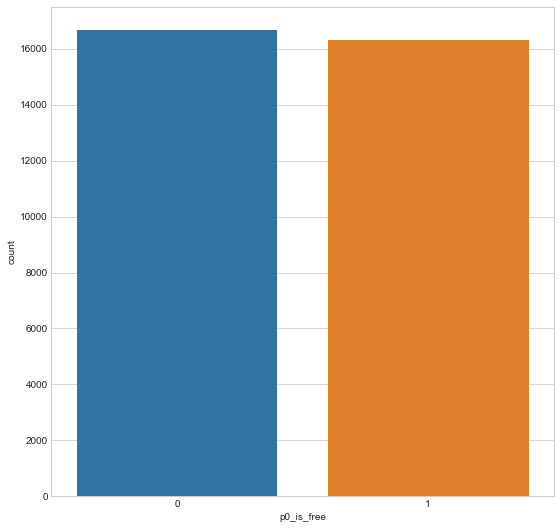

In [17]:
print("Соотношение: {} тиков в простое, {} тиков в работе".format(df.p0_is_free.value_counts()[0], 
                                                                  df.p0_is_free.value_counts()[1]))
print("Соотношение: {:.3f}% / {:.3f}%".format(df.p0_is_free.value_counts()[0] / df.p0_is_free.count() * 100,
                                              df.p0_is_free.value_counts()[1] / df.p0_is_free.count() * 100))
plt.figure(num=1, figsize=(9,9))
sns.countplot(df.p0_is_free)

Соотношение: 16422 тиков в простое, 16542 тиков в работе
Соотношение: 49.818% / 50.182%


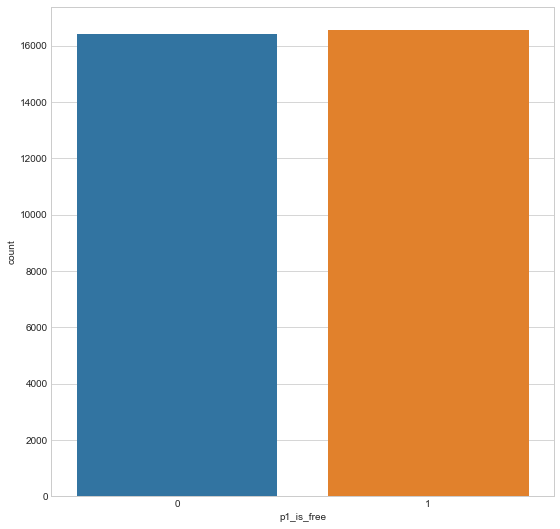

In [18]:
print("Соотношение: {} тиков в простое, {} тиков в работе".format(df.p1_is_free.value_counts()[0], 
                                                                  df.p1_is_free.value_counts()[1]))
print("Соотношение: {:.3f}% / {:.3f}%".format(df.p1_is_free.value_counts()[0] / df.p1_is_free.count() * 100,
                                              df.p1_is_free.value_counts()[1] / df.p1_is_free.count() * 100))
plt.figure(num=1, figsize=(9,9))
sns.countplot(df.p1_is_free)

16837 тиков в простое, 16127 тиков в работе
Соотношение: 51.077% / 48.923%


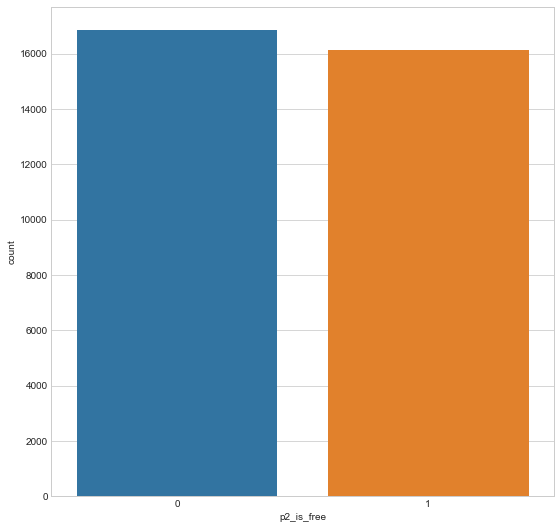

In [19]:
print("{} тиков в простое, {} тиков в работе".format(df.p2_is_free.value_counts()[0], 
                                                     df.p2_is_free.value_counts()[1]))
print("Соотношение: {:.3f}% / {:.3f}%".format(df.p2_is_free.value_counts()[0] / df.p2_is_free.count() * 100,
                                              df.p2_is_free.value_counts()[1] / df.p2_is_free.count() * 100))
plt.figure(num=1, figsize=(9,9))
sns.countplot(df.p2_is_free)

Из графиков и аналитической выкладки видно, что соотношение времени работы и ожидания приблизительно равно 1:1, то есть время работы и простоя процессора примерно одинаково.